In [1]:
# https://github.com/nltk/nltk/issues/3028
! unzip -q /usr/share/nltk_data/corpora/reuters.zip -d /usr/share/nltk_data/corpora/

In [2]:
from nltk.corpus import reuters


documents = reuters.fileids()
print(str(len(documents)) + " documents")
print(str(len(reuters.categories())) + " categories:")
print(reuters.categories()[:10] + ['...'])

10788 documents
90 categories:
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', '...']


In [3]:
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

df = pd.DataFrame(reuters.fileids("acq"), columns=['fileid'])
df['raw'] = df['fileid'].progress_map(lambda f: reuters.raw(f))
df.index = df['fileid'].progress_map(lambda f: int(f.split('/')[1]))
df.index.name = None
df = df.drop(columns=['fileid']).sort_index()

df.sample(3, random_state=12)

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

,raw
12441,GUINNESS TO SELL RETAIL INTERESTS\n Guinness ...
3061,FIRST BOSTON AFFILIATE TO ACQUIRE ALLEGHENY IN...
17810,ATCOR&lt;ATCO.O> SEEKS BUYERS FOR CONSUMER BUS...


In [4]:
df[['headline', 'raw_text']] = df.progress_apply(lambda row: row['raw'].split('\n', 1), axis='columns', result_type='expand')

  0%|          | 0/2369 [00:00<?, ?it/s]

In [5]:
import re


def clean(text):
    # html escape
    text = text.replace('&lt;','<') 
    
    # quotation marks instead of <>
    text = re.sub(r'[<>]', '"', text) 
    
    # drop stock symbols
    text = re.sub(r'[ ]*"[A-Z\.]+"', '', text)
    
    # drop stock symbols
    text = re.sub(r'[ ]*\([A-Z\.]+\)', '', text) 
    
    text = re.sub(r'\bdlr(s?)\b', r'dollar\1', text, flags=re.I)
    text = re.sub(r'\bmln(s?)\b', r'million\1', text, flags=re.I)
    text = re.sub(r'\bpct\b', r'%', text, flags=re.I)
    
    # normalize INC to Inc
    text = re.sub(r'\b(Co|Corp|Inc|Plc|Ltd)\b', lambda m: m.expand(r'\1').capitalize(), text, flags=re.I)
    
    # quotation marks
    text = re.sub(r'"', r'', text)
    
    # multiple whitespace by one
    text = re.sub(r'\s+', ' ', text) 
    
    # typo
    text = re.sub(r'acquisiton', 'acquisition', text) 
    text = re.sub(r'Nippon bLife', 'Nippon Life', text)
    
    # missing space at end of sentence
    text = re.sub(r'COMSAT.COMSAT', 'COMSAT. COMSAT', text)
    #text = re.sub(r'Audio/Video', 'Audio-Video', text)

    return text.strip()

In [6]:
df['text'] = df['raw_text'].progress_map(clean)
df['headline'] = df['headline'].progress_map(clean)

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

In [7]:
# we will drop these articles with only capital letters
df[df['raw_text'].progress_map(lambda t: t.isupper())][['headline', 'raw_text']].head(3)

# drop articles with only capital letters
df = df[df['raw_text'].progress_map(lambda t: not t.isupper())]

df[['headline', 'text']].sample(3, random_state=12)

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

,headline,text
5077,TONY LAMA TO BUY COULSON OF TEXAS Inc,Tony Lama Co Inc said it signed a letter of in...
9844,ETHYL Corp UNITS COMPLETE ACQUISITON,Ethyl Corp said its subsidiaries completed the...
11508,QUANTUM VENTURE UPS COMPUTER NETWORK STAKE,Computer Network Technology Corp said that Qua...


# Named Entity Recognition

In [8]:
import spacy


nlp = spacy.load('en_core_web_sm') 
print(*nlp.pipeline, sep='\n')

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7bc2d867af20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x7bc2d867b700>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7bc2dcf71a80>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7bc2d864e900>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x7bc2d863a340>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x7bc2dcf70970>)


In [9]:
# Test a sample on the nlp pipeline
text = """Hughes Tool Co Chairman W.A. Kistler said its merger with 
Baker International Corp was still under consideration.
We hope to come soon to a mutual agreement, Kistler said.
The directors of Baker filed a law suit in Texas to force Hughes 
to complete the merger."""
text = re.sub(r'\s+', ' ', text).strip()
doc = nlp(text)

print(*[(e.text, e.label_) for e in doc.ents], sep=' ')

('Hughes Tool Co', 'ORG') ('W.A. Kistler', 'PERSON') ('Baker International Corp', 'ORG') ('Kistler', 'PERSON') ('Baker', 'PERSON') ('Texas', 'GPE') ('Hughes', 'ORG')


In [10]:
from spacy import displacy


displacy.render(doc, style='ent')

In general, spaCy’s named-entity recognizer does a good job. In our example, it was able to detect all named entities. The labels of Kistler and Baker in the second and third sentence, however, are not correct. In fact, distinguishing between persons and organizations is quite a challenge for NER models because those entity types are used very similarly. We will resolve such problems later for name-based coreference resolution

If you want to identify domain-specific entities on which the model has not been trained, you can of course train your own model with spaCy. But
training a model requires a lot of training data. Often it is sufficient to specify simple rules for custom entity types. Let's see how to use
rules to detect government organizations like the “Department of Justice” (or alternatively the “Justice Department”) in the Reuters dataset.

## Using Rule-Based Named-Entity Recognition

In [11]:
# from spacy.pipeline import EntityRuler


departments = ['Justice', 'Transportation']
patterns = [
    {
        "label": "GOV", 
        "pattern": [{"TEXT": "U.S.", "OP": "?"},
                    {"TEXT": "Department"}, {"TEXT": "of"}, 
                    {"TEXT": {"IN": departments}, "ENT_TYPE": "ORG"}]
    },
    {
        "label": "GOV", 
        "pattern": [{"TEXT": "U.S.", "OP": "?"},
                    {"TEXT": {"IN": departments}, "ENT_TYPE": "ORG"},
                    {"TEXT": "Department"}]
    },
    {
        "label": "GOV",
        "pattern": [{"TEXT": "Securities"}, {"TEXT": "and"},
                    {"TEXT": "Exchange"}, {"TEXT": "Commission"}]
    }
]

ruler = nlp.add_pipe("entity_ruler", config=dict(overwrite_ents=True))
ruler.add_patterns(patterns)

Each rule consists of a dictionary with a label, in our case the custom entity type GOV, and a pattern that the token sequence must match. You can specify multiple rules for the same label. The first rule, for example, matches sequences of tokens with the texts "U.S." (optional, denoted by "OP": "?"), "Department", "of", and either "Justice" or "Transportation". This and the second rule refine already recognized entities of type ORG. Thus, these patterns must be applied on top and not instead of spaCy’s named-entity model

In [12]:
text = """Justice Department is an alias for the U.S. Department of Justice.
Department of Transportation and the Securities and Exchange Commission
are government organisations, but the Sales Department is not."""
#text = re.sub(r'\s+', ' ', text).strip()

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

## Normalizing Named Entities

One approach to simplify the resolution of different entity mentions to a single name is the normalization or standardization of mentions. We will do a first normalization, which is generally helpful: the removal of unspecific suffixes and prefixes.

In [13]:
text = "Baker International's shares climbed on the New York Stock Exchange."

doc = nlp(text)
print(*[([t.text for t in e], e.label_) for e in doc.ents], sep='\n')

(['Baker', 'International', "'s"], 'ORG')
(['the', 'New', 'York', 'Stock', 'Exchange'], 'ORG')


In the first sentence, the token sequence Baker International's was detected as an entity even though the genitive-s is not part of the company name. A similar case is the article in the New York Stock Exchange. Regardless of whether the article is actually part of the name or not, entities will likely be referenced sometimes with and sometimes without the article. Thus, the general removal of the article and an apostrophe-s simplifies the linking of mentions

In [14]:
from spacy.tokens import Span
from spacy import Language


@Language.component("norm_entities")
def norm_entities(doc):
    ents = []
    
    for ent in doc.ents:
        if ent[0].pos_ == "DET": # leading article
            ent = Span(doc, ent.start+1, ent.end, label=ent.label)
        if len(ent) > 0:
            if ent[-1].pos_ == "PART": # trailing particle like 's
                ent = Span(doc, ent.start, ent.end-1, label=ent.label)
            ents.append(ent)
            
    doc.ents = tuple(ents)
    return doc

nlp.add_pipe("norm_entities")

doc = nlp(text)

displacy.render(doc, style='ent', jupyter=True)

In [15]:
print(*[(t.text, t.ent_type_) for t in doc if t.ent_type_ != ''])

('Baker', 'ORG') ('International', 'ORG') ('New', 'ORG') ('York', 'ORG') ('Stock', 'ORG') ('Exchange', 'ORG')


## Merging Entity Tokens

In many cases, it makes sense to treat compound names like the ones above as single tokens because it simplifies the sentence structure. spaCy pro‐
vides a built-in pipeline function merge_entities for that purpose. We add it to our NLP pipeline and get exactly one token per named-entity

In [16]:
from spacy.pipeline import merge_entities


nlp.add_pipe('merge_entities')

doc = nlp(text)
print(*[(t.text, t.ent_type_) for t in doc if t.ent_type_ != ''])

('Baker International', 'ORG') ('New York Stock Exchange', 'ORG')


Even though merging entities simplifies our blueprints later in this chapter, it may not always be a good idea. Think, for example, about compound entity names like London Stock Exchange. After merging into a single token, the implicit relation of this entity to the city of London will be lost

In [17]:
i = df['text'].sample(1).index[0]
print("Text Number:", i)

text = df['text'].loc[i][:600]
text = re.sub(r'\s+', ' ', text.strip())

print(text)

Text Number: 10146
Lomak Petroleum Inc and Strata Corp, based in Columbus, Ohio, jointly said they entered into a merger agreement for Strata to become a wholly owned subsidiary of Lomak. Under the merger's terms, Strata shareholders will receive 5.7 cts per share of Strata common and warrants to buy about .06 shares of Lomak common at 37.5 cts per share on or before December 31, 1990, for each Strata common share. The merger is subject to approval by the companies' boards and shareholders and agreement of certain Strata creditors, among other things, said the companies.


In [18]:
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

# Coreference Resolution

One of the greatest obstacles in information extraction is the fact that entity mentions appear in many different spellings. Entities are frequently introduced by their full name, while later mentions use abbreviated versions. This is one type of coreference that must resolved to understand what’s going on. Coreference resolution is the task of determining the different mentions of an entity within a single text, for example, abbreviated names, aliases, or pronouns. The result of this step is a group of coreferencing mentions called a mention cluster, for example, {Hughes Tool Co, Hughes, its}.

## Using spaCy’s Token Extensions

We need a way to technically create the link from the different mentions of an entity to the main reference, the referent. After coreference resolu‐
tion, the token for “Kistler” of the example article should point to “(W.A. Kistler, PERSON).” spaCy’s extension mechanism allows us to define custom
attributes, and this is the perfect way to store this kind of information with tokens. Thus, we create two token extensions ref_n (referent’s name) and ref_t (referent’s type). The attributes will be initialized for each token with the specified default values by spaCy for each token.

The custom attributes are accessed via the underscore property of the token. Note that after merge_entities, each entity mention e consists of a single token e[0] where we set the attributes. We could also define the attributes on the entity spans instead of tokens, but we want to use the same mechanism for pronoun resolution later

In [19]:
from spacy.tokens import Token


Token.set_extension('ref_n', default='')
Token.set_extension('ref_t', default='')


@Language.component("init_coref")
def init_coref(doc):
    for e in doc.ents:
        if e.label_ in ['ORG', 'GOV', 'PERSON']:
            e[0]._.ref_n, e[0]._.ref_t = e.text, e.label_
    return doc

In [20]:
nlp.add_pipe("init_coref")

<function __main__.init_coref(doc)>

### Alias Resolution

Our first targets are well-known domain aliases like Transportation Department for “U.S. Department of Transportation” and acronyms like SEC or TWA. A simple solution to resolve such aliases is to use a lookup dictionary.

In [21]:

# acronyms created after cooccurrence analysis
_acronyms = {
    'AMC': 'American Motors Corp',
    'AMI': 'American Medical International Inc',
    'ARCO': 'Atlantic Richfield Co',
    'BIL': 'Brierley Investments Ltd',
    'BP': 'British Petroleum Co Plc',
    'BPI': 'Banco Portugues de Investmento Sarl',
    'CGCT': 'Cie Generale de Constructions',
    'DAF': 'Delhi Australia Fund',
    'EC': 'European Community',
    'ETL': 'Equiticorp Tasman Ltd',
    'FCC': 'Federal Communications Commission',
    'FDA': 'Food and Drug Administration',
    'FHLBB': 'Federal Home Loan Bank Board',
    'FIRB': 'Foreign Investment Review Board',
    'FTC': 'Federal Trade Commission',
    'ICC': 'Interstate Commerce Commission',
    'IDC': 'International Digital Communications Planning Inc',
    'ITJ': 'International Telecom Japan Inc',
    'KDD': 'Kokusai Denshin Denwa Co Ltd',
    'PCGG': 'Presidential Commission on Good Government',
    'PSA': 'Pacific Southwest Airlines',
    'SMC': 'San Miguel Corp',
    'TWA': 'Trans World Airlines Inc',
    'UCPB': 'United Coconut Planters Bank'
}

# add acronyms (all acronyms are organizations)
alias_lookup = {acro: (text, 'ORG') for (acro, text) in _acronyms.items()}

alias_lookup['SEC'] = ('Securities and Exchange Commission', 'GOV')
    
alias_list = {
    ('U.S. Department of Justice', 'GOV'): ['U.S. Department of Justice',
                                            'Department of Justice', 
                                            'U.S. Justice Department', 
                                            'Justice Department'],
    ('U.S. Department of Transportation', 'GOV'): ['U.S. Department of Transportation',
                                                   'U.S. Transportation Department',
                                                   'Department of Transportation',
                                                   'Transportation Department',
                                                   'DOT'],
    ('USAir Group Inc', 'ORG'): ['USAir Group Inc', 
                                 'USAir Group Inc.',
                                 'US Air Corp', 
                                 'US Air Corp.',
                                 'USAir Group', 
                                 'USAir Group Inc',
                                 'USAir Group Inc.',
                                 'US Air', 
                                 'USAir', 
                                 'U.S. Air',
                                 'USAIR Group',
                                 'U.S. Air Group Inc.'],
    ('Trans World Airlines Inc', 'ORG'): ['Transworld Airlines', 
                                          'Transworld Airlines Inc', 
                                          'Trans World Airlines'],
}         

# invert alias_list; overwrites entries in acronyms like DOT
alias_lookup.update({alias: ent for (ent, aliases) in alias_list.items() 
                                for alias in aliases})

In [22]:
for token in ['Transportation Department', 'DOT', 'SEC', 'TWA']:
    print(token, ':', alias_lookup[token])

Transportation Department : ('U.S. Department of Transportation', 'GOV')
DOT : ('U.S. Department of Transportation', 'GOV')
SEC : ('Securities and Exchange Commission', 'GOV')
TWA : ('Trans World Airlines Inc', 'ORG')


In [23]:
@Language.component("alias_resolver")
def alias_resolver(doc):
    """Lookup aliases and store result in ref_t, ref_n"""
    for ent in doc.ents:
        token = ent[0].text
        if token in alias_lookup:
            a_name, a_type = alias_lookup[token]
            ent[0]._.ref_n, ent[0]._.ref_t = a_name, a_type
    return propagate_ent_type(doc)

Once we have resolved the aliases, we can also correct the type of the named-entity in
case it was misidentified

In [24]:
@Language.component("propagate_ent_type")
def propagate_ent_type(doc):
    """propagate entity type stored in ref_t"""
    ents = []
    for e in doc.ents:
        if e[0]._.ref_n != '': # if e is a coreference
            e = Span(doc, e.start, e.end, label=e[0]._.ref_t)
        ents.append(e)
    doc.ents = tuple(ents)
    return doc

In [25]:
nlp.add_pipe('alias_resolver')

<function __main__.alias_resolver(doc)>

### Resolving Name Variations

Alias resolution works only if the aliases are known up front. But because articles contain variations of almost any names, it is not feasible to build a dictionary for all of them. Let's take a look again at the recognized named entities in the first sentences:

In [26]:
text = """
Hughes Tool Co Chairman W.A. Kistler said its merger with 
Baker International Corp. was still under consideration.
We hope to come to a mutual agreement, Kistler said.
Baker will force Hughes to complete the merger.
"""
text = re.sub(r'\s+', ' ', text).strip() 

doc = nlp(text) 
displacy.render(doc, style='ent', jupyter=True)

Here you find the coreference “Kistler” for W.A. Kistler (PERSON), “Baker” for Baker International Corp (ORG), and “Hughes” for Hughes Tool Co (ORG). And as we can see, abbreviated company names are often mistaken for people (Baker), especially when they are used in impersonated form. We will resolve this coreferences and assign the correct entity types to each mention.

For that, we will exploit a common pattern in news articles. An entity is usually introduced first by its full name, while later mentions use abbreviated versions. Thus, we will resolve the secondary references by matching the names to the first mention of an entity. Of course, this is a heuristic rule that could produce false matches. For example, Hughes could also refer in the same article to the company and to the legen‐
dary entrepreneur Howard Hughes (who indeed founded Hughes Tool Co.). But such cases are rare in our dataset, and I decided to accept that uncertainty in favor of the many cases where our heuristics works correctly. 

We define a simple rule for name matching: a secondary mention matches a primary mention if all of its words appear in the primary mention in the same order.

In [27]:
def name_match(m1, m2):
    # ignore parentheses and dots
    m2 = re.sub(r'[()\.]', '', m2)
    
    # \b marks word boundary
    m2 = r'\b' + m2 + r'\b' 
    m2 = re.sub(r'\s+', r'\\b.*\\b', m2)
    return re.search(m2, m1, flags=re.I) is not None

The secondary mention of Hughes Co., for example, would be converted into `'\bHughes\b.*\bCo\b'`, which matches Hughes Tool Co. The \b ensures that only whole words match and not subwords like Hugh. Based on this matching logic, the function name_resolver shown next implements the name-based coreference resolution for organizations and persons:

In [28]:
@Language.component("name_resolver")
def name_resolver(doc):
    """create name-based reference to e1 as primary mention of e2"""
    ents = [e for e in doc.ents if e.label_ in ['ORG', 'PERSON']]
    for i, e1 in enumerate(ents):
        for e2 in ents[i+1:]:
            if name_match(e1[0]._.ref_n, e2[0].text): 
                e2[0]._.ref_n = e1[0]._.ref_n
                e2[0]._.ref_t = e1[0]._.ref_t
    return propagate_ent_type(doc)

nlp.add_pipe('name_resolver')

<function __main__.name_resolver(doc)>

In [29]:
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

### Name Normalization

Even though our name resolution unifies company mentions within an article, the company names are still inconsistent across articles. We find Hughes Tool Co. in one article and Hughes Tool in another one. An entity linker can be used to link different entity mentions to a unique canonical representation, but in absence of an entity linker we will use the (resolved) name entity as its unique identifier. Because of the previous steps for coreference resolution, the resolved names are always the first, and thus usually most complete, mentions in an article. So, the potential for errors is not that large. Still, we have to harmonize company mentions by removing the legal suffixes like Co. or Inc. from company names. The following function uses a regular expression to achieve this

In [30]:
def strip_legal_suffix(text):
    return re.sub(r'(\s+and)?(\s+|\b(Co|Corp|Inc|Plc|Ltd)\b\.?)*$', '', text)

print(strip_legal_suffix('Hughes Tool Co'))

Hughes Tool


In [31]:
@Language.component("norm_names")
def norm_names(doc):
    for t in doc:
        if t._.ref_n != '' and t._.ref_t in ['ORG']:
            t._.ref_n = strip_legal_suffix(t._.ref_n)
            if t._.ref_n == '':
                t._.ref_t = ''
    return doc

nlp.add_pipe("norm_names")

<function __main__.norm_names(doc)>

## Entity Linking

So far we developed a pipeline of operations with the purpose of unifying the different mentions of named entities. But all this is string based, and
except for the syntactical representation, we have no connection between the string U.S. Department of Justice and the represented real-world entity. The task of an entity linker, in contrast, is to resolve named entities globally and link them to a uniquely identified real-world entity. Entity linking makes the step from “strings to things.” Technically, this means that each mention is mapped to a URI. URIs, in turn, address entities in an existing knowledge base. This can be a public ontology, like Wikidata or DBpedia, or a private knowledge base in your company. URIs can be URLs (e.g., web pages) but do not have to be. The U.S. Department of Justice, for example, has the Wikidata URI http://www.wikidata.org/entity/Q1553390, which is also a web page where you find information about this entity. If you build your own knowledge base, it is not necessary to have a web page for each URI; they just must be unique. DBpedia and Wikidata, by the way, use different URIs, but you will find the Wikidata URI on DBpedia as a cross-reference. Both, of course, contain links to the Wikipedia web page.

Entity linking is simple if an entity is mentioned by a fully qualified name, like the U.S. Department of Justice. But the term Department of Justice without U.S. is already quite ambiguous because many states have a “Department of Justice.” The actual meaning depends on the context, and the task of an entity linker is to map such an ambiguous mention context-sensitively to the correct URI. This is quite a challenge and still an area of ongoing research. A common solution for entity linking in business projects is the usage of a public service.


### Services for Entity Linking

There are several web services for named-entity resolution and linking. `DBpedia Spotlight`, for example, is an open service that links to DBpedia resources. You can either use the public web service or deploy a copy in your own environment. A commercial alternative for such a service is `TextRazor`, which even provides a nice Python library for easy integration into your own project.



Alternatively, you could create your own entity linker. A simple solution would be a name-based lookup dictionary. But that does not take the context into account and would not resolve ambiguous names for different entities. For that, you need a more sophisticated approach. State-of-the-art solutions use embeddings and neural models for entity linking. spaCy also provides such an entity linking functionality. To use spaCy’s entity linker, you first have to create embeddings for the real-world entities, which capture their semantics based on descriptions you specify. Then you can train a model to learn the context-sensitive mapping of mentions to the correct URI.

## Creating a Co-Occurrence Graph

We spent much effort to normalize named entities and to resolve at least the in-document coreferences. Now we are finally ready to analyze a first relationship among pairs of entities: their joint mention in an article. For this, we will create a co-occurrence graph, the simplest form of a knowledge graph. The nodes in the co-occurrence graph are the entities, e.g. organizations. Two entities share an (undirected) edge if they are mentioned in the same context, for example, within an article, a paragraph, or a sentence.

In [32]:
from itertools import combinations
import math


def extract_coocs(doc, include_types):
    ents = set([(e[0]._.ref_n, e[0]._.ref_t) for e in doc.ents if e[0]._.ref_t in include_types])
    yield from combinations(sorted(ents), 2)
    
batch_size = 100
batches = math.ceil(len(df)/batch_size)
coocs = []

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        try:
            coocs.extend([(df.index[i+j], *c) for c in extract_coocs(doc, ['ORG', 'GOV'])])
        except:
            print(f"Index {i+j}")
            print(df['text'][i+j][0:100])
            raise

  0%|          | 0/22 [00:00<?, ?it/s]

In [33]:
print(*coocs[:3], sep='\n')

(10, ('Computer Terminal Systems', 'ORG'), ('Dot Matrix', 'ORG'))
(10, ('Computer Terminal Systems', 'ORG'), ('Sedio N.V. of Lugano', 'ORG'))
(10, ('Computer Terminal Systems', 'ORG'), ('Woodco', 'ORG'))


In information extraction, it is always recommended to have some kind of traceability that allows you to identify the source of the information in the case of problems. Therefore, we retain the index of the article, which in our case is the file ID of the Reuters corpus, with each co-occurrence tuple (here the ID 10). Based on this list, we generate a DataFrame with exactly one entry per entity combination, its frequency, and the article IDs (limited to five) where this co-occurrence was found

In [34]:
coocs = [([id], *e1, *e2) for (id, e1, e2) in coocs]
cooc_df = pd.DataFrame.from_records(coocs, columns=('article_id', 'ent1', 'type1', 'ent2', 'type2')) 
cooc_df = cooc_df.groupby(['ent1', 'type1', 'ent2', 'type2'])['article_id'] \
                 .agg(['count', 'sum']) \
                 .rename(columns={'count': 'freq', 'sum': 'articles'}) \
                 .reset_index().sort_values('freq', ascending=False)
cooc_df['articles'] = cooc_df['articles'].progress_map(lambda lst: ','.join([str(a) for a in lst[:5]]))
cooc_df.head(3)

  0%|          | 0/12956 [00:00<?, ?it/s]

,ent1,type1,ent2,type2,freq,articles
5273,Cyclops,ORG,Dixons Group,ORG,22,"4303,4933,6093,6402,7110"
12705,Trans World Airlines,ORG,USAir Group,ORG,22,"1735,1771,1836,1862,1996"
204,AFG Industries,ORG,Wagner,ORG,20,"6410,6463,6630,6665,6815"


### Visualizing the Graph with NetworkX

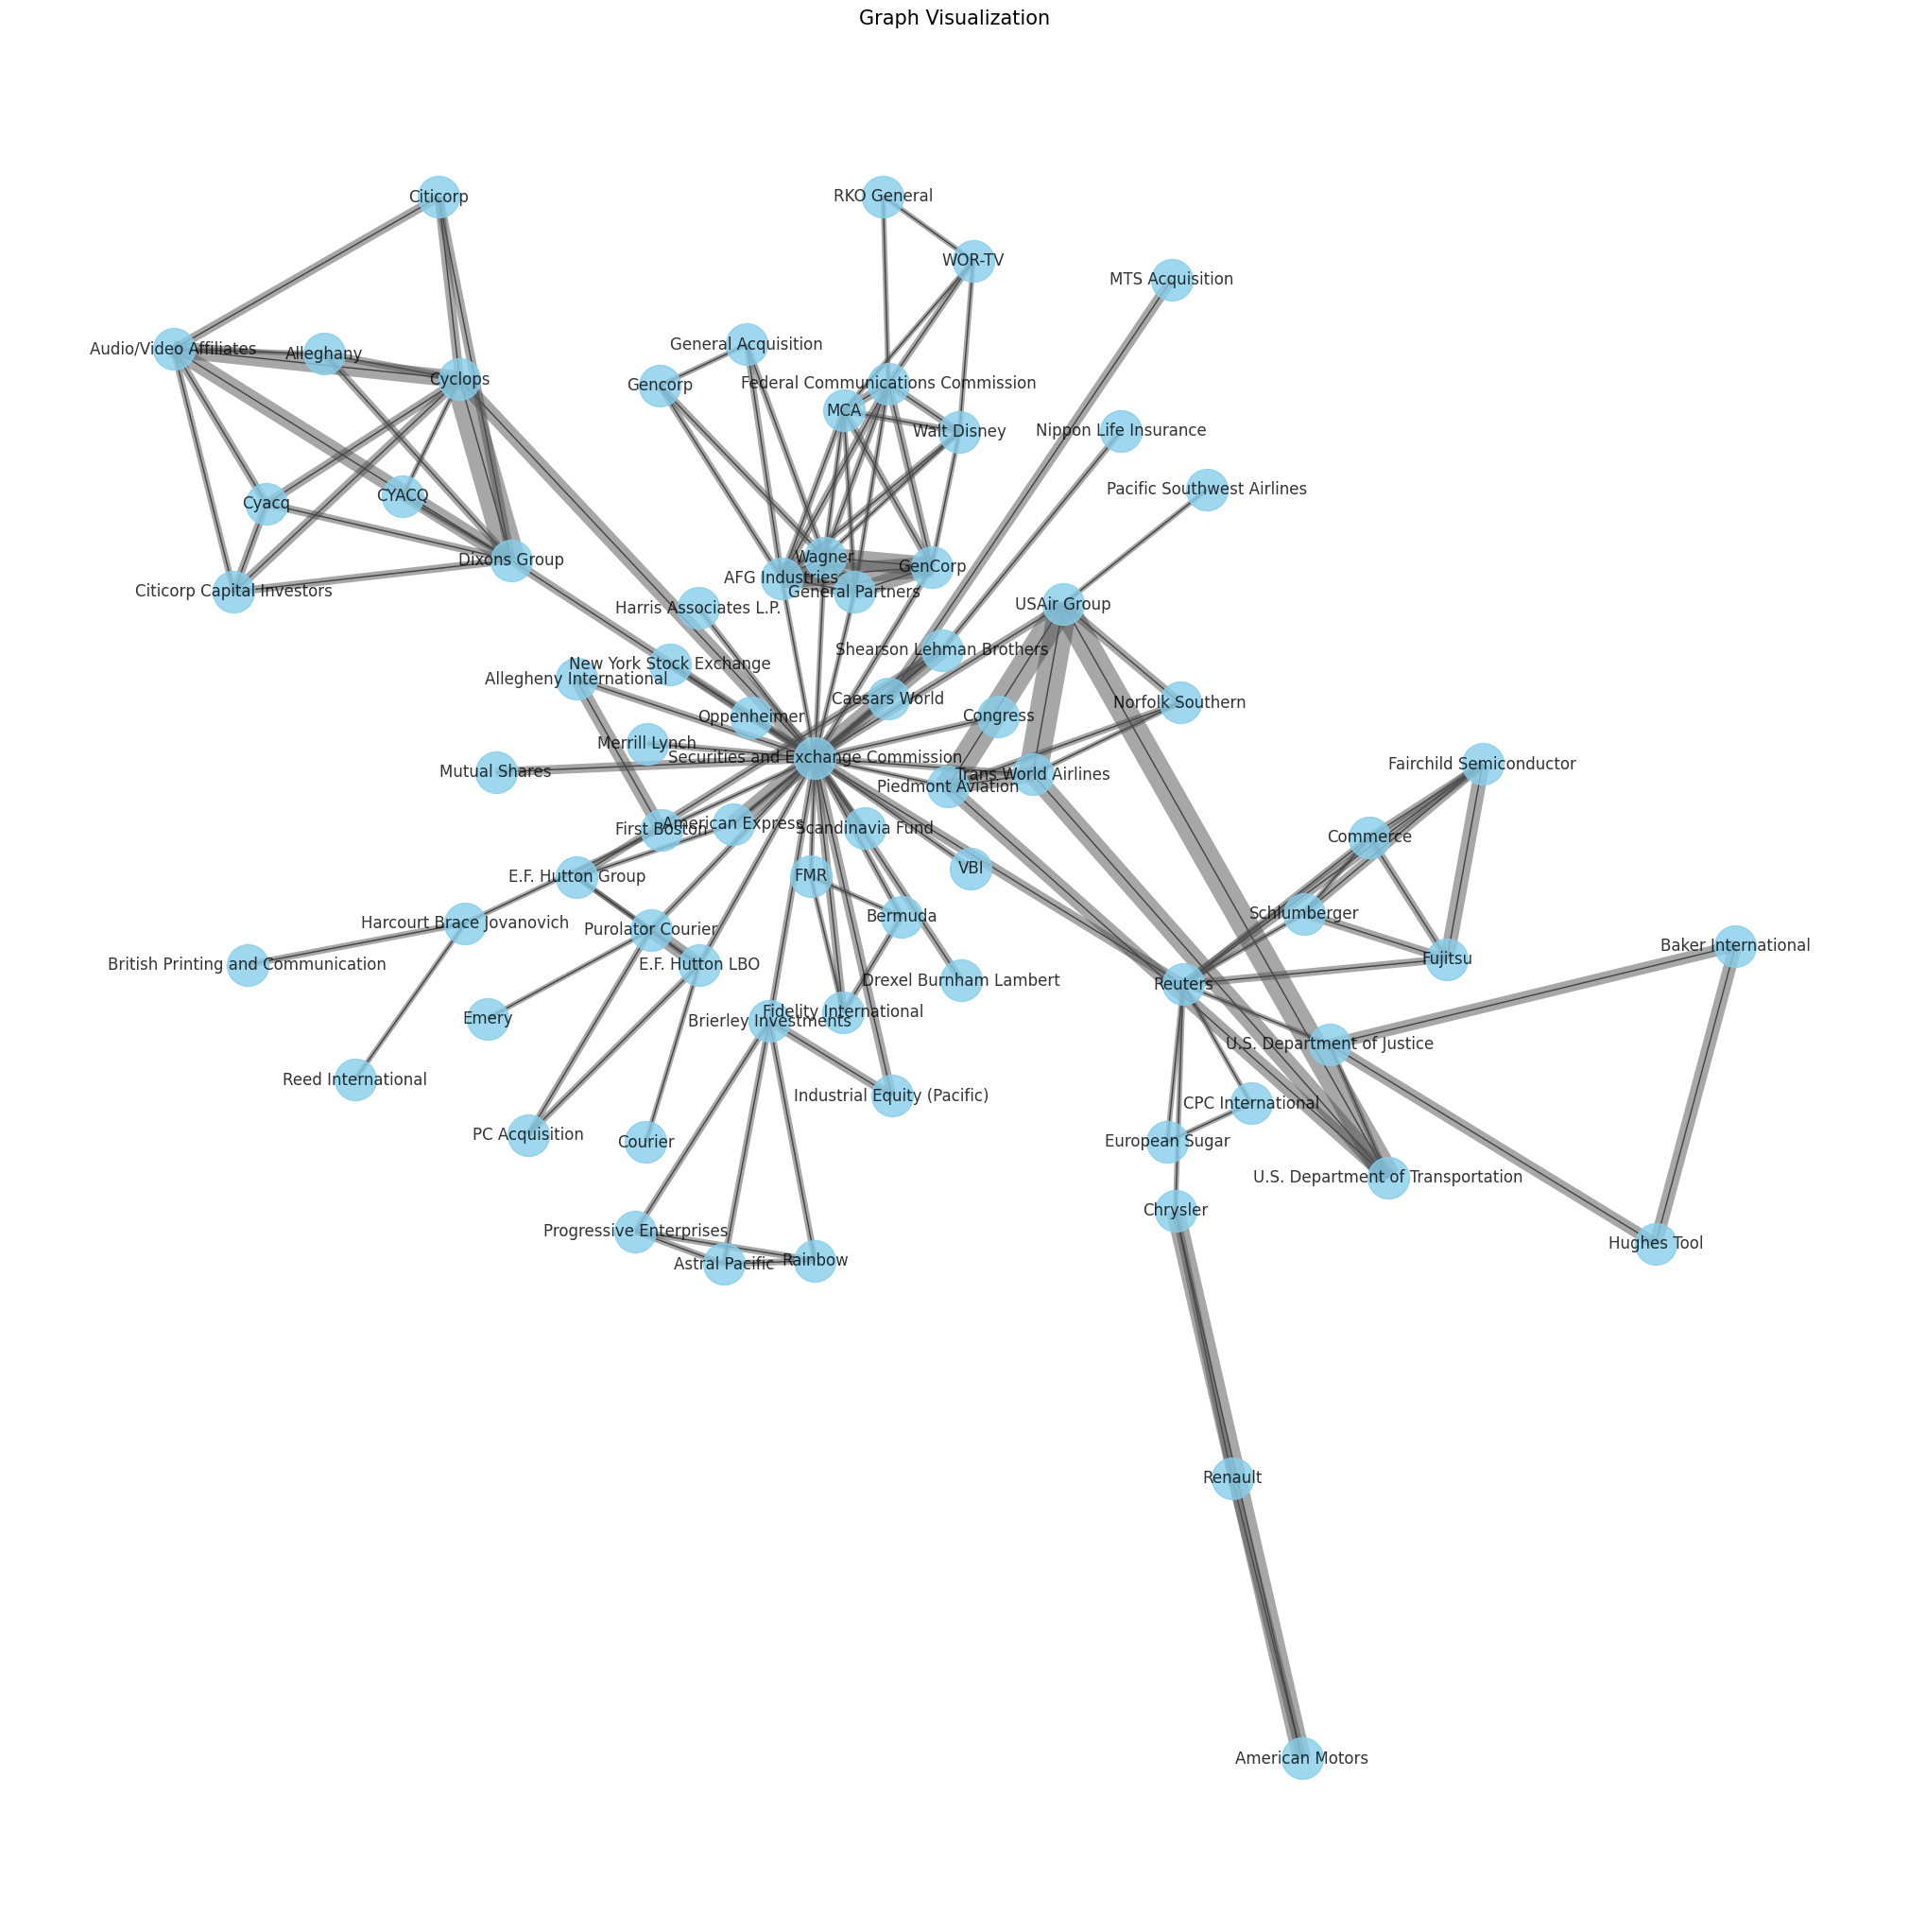

In [35]:
import networkx as nx
import matplotlib.pyplot as plt


network_df = cooc_df[['ent1', 'ent2', 'articles', 'freq']].query('freq > 3').rename(columns={'freq': 'weight'})
graph = nx.from_pandas_edgelist(network_df, source='ent1', target='ent2', edge_attr=True)

# identify the greatest component (connected subgraph) and plot only that one
giant_component = sorted(nx.connected_components(graph), key=len, reverse=True)
graph = graph.subgraph(giant_component[0])

pos = nx.kamada_kawai_layout(graph, weight='weight')
# pos = nx.fruchterman_reingold_layout(graph, weight='weight')
# pos = nx.circular_layout(graph)

_ = plt.figure(figsize=(20, 20))
nx.draw(graph, pos, node_size=1000, node_color='skyblue', alpha=0.8, with_labels = True)
plt.title('Graph Visualization', size=15)

for (node1, node2, data) in graph.edges(data=True):
    width = data['weight'] 
    _ = nx.draw_networkx_edges(graph, pos, edgelist=[(node1, node2)], width=width, edge_color='#505050', alpha=0.5)

plt.show()

## Relation Extraction

Even though the co-occurrence graph already gave us some interesting insights about company networks, it does not tell us anything about the types of the relations. Take, for example, the subgraph formed by the companies Schlumberger, Fairchild Semiconductor, and Fujitsu in the upper right corner of the graph above. So far, we know nothing about the relations between those companies; the information is still hidden in sentences like these:

`Fujitsu wants to expand. It plans to acquire 80% of Fairchild Corp, an industrial unit of Schlumberger.`

We will now focus on pattern-based relation extraction. The first and simpler approach searches for token phrases of the form “subject-predicate-object.” The second one uses the syntactical structure of a sentence, the dependency tree, to get more precise results at the price of more complex rules. In the end, we will generate a knowledge graph based on the four relations: acquires, sells, subsidiary-of, and chairperson-of. To be honest, we will use relaxed definitions of acquires and sells, which are easier to identify. They will also match sentences like “Fujitsu plans to acquire 80% of Fairchild Corp” or even “Fujitsu withdraws the option to acquire Fairchild Corp.”

Relation extraction is a complicated problem because of the ambiguity of natural language and the many different kinds and variations of relations. Model-based approaches to relation extraction are a current topic in research. 

### Extracting Relations Using Phrase Matching

In [36]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", config=dict(overwrite_ents=True))
ruler.add_patterns(patterns)

custom_pipes = ['norm_entities', 'merge_entities', 'init_coref', 'alias_resolver', 'name_resolver', 'norm_names']

for p in custom_pipes:
    nlp.add_pipe(p)

In [37]:
text = """Fujitsu plans to acquire 80% of Fairchild Corp, an industrial unit of Schlumberger."""
text = re.sub('\s+', ' ', text).strip()

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

We could find the relations in this sentence by searching for patterns like these:

- ORG {optional words, not ORG} acquire {optional words, not ORG} ORG
- ORG {optional words, not ORG} unit of {optional words, not ORG} ORG

spaCy’s rule-based matcher allows us to find patterns that not only can involve the textual tokens but also their properties, like the lemma or part of speech. To use it, we must first define a matcher object. Then we can add rules.

In [38]:
from spacy.matcher import Matcher


matcher = Matcher(nlp.vocab)

acq_synonyms = ['acquire', 'buy', 'purchase']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'POS': 'VERB', 'LEMMA': {'IN': acq_synonyms}},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('acquires', [pattern])

subs_synonyms = ['subsidiary', 'unit']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'LOWER': {'IN': subs_synonyms}}, {'TEXT': 'of'},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('subsidiary-of', [pattern])

The first pattern is for the acquires relation. It returns all spans consisting of an organization, followed by arbitrary tokens that are not organizations, a verb matching several synonyms of acquire, again arbitrary tokens, and finally the second organization. The second pattern for subsidiary-of works similarly.

The expressions are hard to read. One reason is that we used the custom attribute ref_t instead of the standard ENT_TYPE. This is necessary to match coreferences that are not marked as entities, e.g., pronouns. Another one is that we have included some NOT_IN clauses. This is because rules with the asterisk operator `(*)` are always dangerous as they search patterns of unbounded length. Additional conditions on the tokens can reduce the risk for false matches. For example, we want to match “Fairchild, an industrial unit of Schlumberger” for the subsidiary-of relation, but not “Fujitsu mentioned a unit of Schlumberger.” When developing rules, you always have to pay for precision with complexity. We will discuss the problems of the acquires relation on that aspect in a minute

In [39]:
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'LOWER': {'IN': subs_synonyms}}, # predicate
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('rev-subsidiary-of', [pattern])

def extract_rel_match(doc, matcher):
    for sent in doc.sents:
        for match_id, start, end in matcher(sent):
            # matched span
            span = sent[start:end]
            
            # rule name
            pred = nlp.vocab.strings[match_id]
            subj, obj = span[0], span[-1]
            
            # reversed relation
            if pred.startswith('rev-'): 
                subj, obj = obj, subj
                pred = pred[4:]
                
            yield ((subj._.ref_n, subj._.ref_t), pred, (obj._.ref_n, obj._.ref_t))

The predicate is determined by the name of the rule; the involved entities are simply the first and last tokens of the matched span. We restrict the search to the sentence level because in a whole document we would have a high risk of finding false positives spanning multiple sentences. 

Usually, the rules match in the order “subject-predicate-object,” but often the entities appear in the text in reversed order, like in “the Schlumberger unit Fairchild Corp.” Here, the order of entities with regard to the subsidiary-of relation is “object-predicate-subject.”

In [40]:
text = """
Fujitsu plans to acquire 80% of Fairchild Corp, an industrial unit of Schlumberger. 
The Schlumberger unit Fairchild Corp received an offer.
"""
text = re.sub('\s+', ' ', text) 

doc = nlp(text)
print(*extract_rel_match(doc, matcher), sep='\n')

(('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
(('Fairchild', 'ORG'), 'subsidiary-of', ('Schlumberger', 'ORG'))
(('Fairchild', 'ORG'), 'subsidiary-of', ('Schlumberger', 'ORG'))


Although the rules work nicely for our examples, the rule for acquires is not very reliable. The verb acquire can appear in many different constellations of entities. Thus, there is a high probability for false matches like below

In [41]:
text = "Fairchild Corp was acquired by Fujitsu."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('Fairchild', 'ORG'), 'acquires', ('Fujitsu', 'ORG'))


In [42]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('NEC', 'ORG'), 'acquires', ('Fairchild', 'ORG'))


Obviously, our rule wasn’t made for passive clauses (“was acquired by”) where the subject and object switch positions. We also cannot handle insertions containing named entities or negations because they produce false matches. To treat those cases correctly, we need knowledge about the syntactical structure of the sentence. And we get that from the dependency tree.

In [43]:
# let’s first remove the unreliable rule for acquires from the matcher
if matcher.has_key("acquires"): 
    matcher.remove("acquires")

### Extracting Relations Using Dependency Trees

The grammatical rules of a language impose a syntactical structure on each sentence. Each word serves a certain role in relation to the other words. A noun, for example, can be the subject or the object in a sentence; it depends on its relation to the verb. In linguistic theory, the words of a sentence are hierarchically interdependent, and the task of the parser in an NLP pipeline is to reconstruct these dependencies. The result is a dependency tree, which can also be visualized by displacy

In [44]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 100})

Each node in the dependency tree represents a word. The edges are labeled with the dependency information. The root is usually the predicate of the sentence, in this case acquired, having a subject (nsubj) and an object (obj) as direct children. This first level, root plus children, already represents the essence of the sentence “Fujitsu acquired Fairchild Corp.”

In [45]:
text = "Fairchild Corp was acquired by Fujitsu."
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 100})

In this case, the auxiliary verb (auxpass) signals that acquired was used in passive form and Fairchild is the passive subject (nsubjpass).

Note that the values of the dependency labels depend on the corpus the parser model was trained on. They are also language dependent because different languages have different grammar rules. So, you definitely need to check which tag set is used by the dependency parser

In [46]:
# Actually we search for the shortest path between the subject running through our predicate (verb) to the object.
# subject and object are organizations in our examples.

# - bfs: breadth first searching the closest subject/object 
# - is_passive: checks if noun or verb is in passive form
# - find_subj: searches left part of tree for subject
# - find_obj: searches right part of tree for object

from collections import deque


def bfs(root, ent_type, deps, first_dep_only=False):
    """Return first child of root (included) that matches
    ent_type and dependency list by breadth first search.
    Search stops after first dependency match if first_dep_only
    (used for subject search - do not "jump" over subjects)"""
    
    to_visit = deque([root]) # queue for bfs

    while len(to_visit) > 0:
        child = to_visit.popleft()
        # print("child", child, child.dep_)
        if child.dep_ in deps:
            if child._.ref_t == ent_type:
                return child
            elif first_dep_only: # first match (subjects)
                return None
        elif child.dep_ == 'compound' and \
             child.head.dep_ in deps and \
             child._.ref_t == ent_type: # check if contained in compound
            return child
        to_visit.extend(list(child.children))
        
    return None


def is_passive(token):
    if token.dep_.endswith('pass'): # noun
        return True
    for left in token.lefts: # verb
        if left.dep_ == 'auxpass':
            return True
    return False


def find_subj(pred, ent_type, passive):
    """Find closest subject in predicates left subtree or
    predicates parent's left subtree (recursive).
    Has a filter on organizations."""
    for left in pred.lefts:
        if passive: # if pred is passive, search for passive subject
            subj = bfs(left, ent_type, ['nsubjpass', 'nsubj:pass'], True)
        else:
            subj = bfs(left, ent_type, ['nsubj'], True)
        if subj is not None: # found it!
            return subj
    if pred.head != pred and not is_passive(pred): 
        return find_subj(pred.head, ent_type, passive) # climb up left subtree
    else:
        return None

    
def find_obj(pred, ent_type, excl_prepos):
    """Find closest object in predicates right subtree.
    Skip prepositional objects if the preposition is in exclude list.
    Has a filter on organizations."""
    for right in pred.rights:
        obj = bfs(right, ent_type, ['dobj', 'pobj', 'iobj', 'obj', 'obl'])
        if obj is not None:
            if obj.dep_ == 'pobj' and obj.head.lemma_.lower() in excl_prepos: # check preposition
                continue
            return obj
    return None

def extract_rel_dep(doc, pred_name, pred_synonyms, excl_prepos=[]):
    for token in doc:
        if token.pos_ == 'VERB' and token.lemma_ in pred_synonyms:
            pred = token
            passive = is_passive(pred)
            subj = find_subj(pred, 'ORG', passive)
            if subj is not None:
                obj = find_obj(pred, 'ORG', excl_prepos)
                if obj is not None:
                    if passive: # switch roles
                        obj, subj = subj, obj
                    yield ((subj._.ref_n, subj._.ref_t), pred_name, (obj._.ref_n, obj._.ref_t))

In [47]:
text = """Fujitsu said that Schlumberger Ltd has arranged to sell its stake in Fairchild Inc."""
doc = nlp(text)
print(*extract_rel_dep(doc, 'sells', ['sell']), sep='\n')

(('Schlumberger', 'ORG'), 'sells', ('Fairchild', 'ORG'))


In this case, Fairchild Inc. is the closest object in the dependency tree to sell and identified correctly as the object of the investigated relation. But to be the “closest” is not always sufficient.

In [48]:
text = "Schlumberger Ltd has arranged to sell to Fujitsu its stake in Fairchild Inc."
doc = nlp(text)
print(*extract_rel_dep(doc, 'sells', ['sell']), sep='\n')

(('Schlumberger', 'ORG'), 'sells', ('Fujitsu', 'ORG'))


In [49]:
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 80})

Actually, we have a three-way relation here: Schlumberger sells Fairchild to Fujitsu. Our sells relation is intended to have the meaning “one company sells [whole or parts of] another company.” The other part is covered by the acquires relation. But how can we detect the right object here? Both Fujitsu and Fairchild are prepositional objects in this sentence (dependency pobj), and Fujitsu is the closest. The preposition is the
key: Schlumberger sells something “to” Fujitsu, so that’s not the relation we are looking for. The purpose of the parameter `excl_prepos` in the extraction function is to skip objects with the specified prepositions. Here is the output without (A) and with (B) preposition filter

In [50]:
print("A:", *extract_rel_dep(doc, 'sells', ['sell']))
print("B:", *extract_rel_dep(doc, 'sells', ['sell'], ['to', 'from']))

A: (('Schlumberger', 'ORG'), 'sells', ('Fujitsu', 'ORG'))
B:


In [53]:
texts = [ 
     "Fairchild Corp was bought by Fujitsu.", # 1
     "Fujitsu, a competitor of NEC Co, acquired Fairchild Inc.", # 2
     "Fujitsu is expanding. The company made an offer to acquire 80% of Fairchild Inc.", # 3
     "Fujitsu plans to acquire 80% of Fairchild Corp.", # 4
     "Fujitsu plans not to acquire Fairchild Corp.", # 5
     "The competition forced Fujitsu to aquire Fairchild Corp." # 6
]

acq_synonyms = ['acquire', 'buy', 'purchase']

for i, text in enumerate(texts):
    doc = nlp(text)
    rels = extract_rel_dep(doc, 'acquires', acq_synonyms, ['to', 'from'])
    print(f'{i+1}:', *rels)

1: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
2: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
3:
4: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
5: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
6:


As we can see, the relations in the 1,2,4 have been correctly extracted. Sentence 5, however, contains a negation and still returns acquires. This is a typical case of a false positive. We could extend our rules to handle this case correctly, but negations are rare in our corpus, and we accept the uncertainty in favor of the simpler algorithm. Sentence 6, in contrast, is an example for a possible false negative. Even though the relation was mentioned, it was not detected because the subject in this sentence is competition and not one of the companies. 

Actually, dependency-based rules are inherently complex, and every approach to make them more precise results in even more complexity. It is a challenge to find a good balance between precision (fewer false positives) and recall (fewer false negatives) without making the code too complex.
Despite those deficiencies, the dependency-based rule still yields good results. This last step in the process, however, depends on the correctness of named-entity recognition, coreference resolution, and dependency parsing, all of which are not working with 100% accuracy. So, there will always be some false positives and false negatives. But the approach is good enough to produce highly interesting knowledge graphs

## Creating the Knowledge Graph

Now that we know how to extract certain relationships, we can put everything together and create a knowledge graph from the entire Reuters corpus. We will extract organizations, persons and the four relations “acquires,” “sells,” “subsidiary-of,” and “executive-of.”

In [54]:
ceo_synonyms = ['chairman', 'president', 'director', 'ceo', 'executive']
pattern = [{'ENT_TYPE': 'PERSON'},
           {'ENT_TYPE': {'NOT_IN': ['ORG', 'PERSON']}, 'OP': '*'}, 
           {'LOWER': {'IN': ceo_synonyms}}, {'TEXT': 'of'},
           {'ENT_TYPE': {'NOT_IN': ['ORG', 'PERSON']}, 'OP': '*'}, 
           {'ENT_TYPE': 'ORG'}] 
matcher.add('executive-of', [pattern])

pattern = [{'ENT_TYPE': 'ORG'}, 
           {'LOWER': {'IN': ceo_synonyms}},
           {'ENT_TYPE': 'PERSON'}] 
matcher.add('rev-executive-of', [pattern])

In [55]:
def extract_rels(doc):
    yield from extract_rel_match(doc, matcher)
    yield from extract_rel_dep(doc, 'acquires', acq_synonyms, ['to', 'from'])
    yield from extract_rel_dep(doc, 'sells', ['sell'], ['to', 'from'])

In [56]:
batch_size = 20
batches = math.ceil(len(df) / batch_size)

rels = []

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        rels.extend([(df.index[i+j], *r) for r in extract_rels(doc)])

  0%|          | 0/108 [00:00<?, ?it/s]

In [57]:
# unpack subject and object 
rels = [(a_id, *subj, pred, *obj) for (a_id, subj, pred, obj) in rels]

# create data frame
rel_df = pd.DataFrame.from_records(rels, columns=('article_id', 'subj', 'subj_type', 'pred', 'obj', 'obj_type'))

# false positives: subject cannot be object
rel_df = rel_df.query('subj != obj')

# filter entities that were not correctly detected tokenizer produces "-owned XYZ company"
rel_df = rel_df[~rel_df['subj'].str.startswith('-own')]
rel_df = rel_df[~rel_df['obj'].str.startswith('-own')]

# drop duplicate relations (within an article)
rel_df = rel_df.drop_duplicates()

# aggregate to produce one record per relation
rel_df['article_id'] = rel_df['article_id'].map(lambda a: [a])
rel_df = rel_df.groupby(['subj', 'subj_type', 'pred', 'obj', 'obj_type'])['article_id'] \
                 .agg(['count', 'sum']) \
                 .rename(columns={'count': 'freq', 'sum': 'articles'}) \
                 .reset_index().sort_values('freq', ascending=False)

rel_df['articles'] = rel_df['articles'].map(lambda lst: ','.join(list(set([str(a) for a in lst]))))
rel_df.head(10)

,subj,subj_type,pred,obj,obj_type,freq,articles
837,Trans World Airlines,ORG,acquires,USAir Group,ORG,7,"1862,2950,5671,7650,1836,3013,5750"
160,Chrysler,ORG,acquires,American Motors,ORG,5,"3795,3100,7796,3056,3198"
237,Dart Group,ORG,acquires,Supermarkets General,ORG,5,"3912,3242,3313,5352,9230"
782,Shearson Lehman Brothers,ORG,subsidiary-of,American Express,ORG,4,"7024,2768,6944,2543"
761,Samuel Heyman,PERSON,executive-of,GAF,ORG,4,"11661,11504,16513,15063"
579,Minories Finance Limited,ORG,subsidiary-of,Bank of England,ORG,3,"12053,12068,12339"
1,A. William Reynolds,PERSON,executive-of,GenCorp,ORG,3,"6665,11492,9638"
299,Esso Exploration and Production Australia,ORG,subsidiary-of,Exxon,ORG,3,"11236,11177,11213"
850,USAir Group,ORG,acquires,Piedmont Aviation,ORG,3,"3039,3153,7791"
746,Ronald Perelman,PERSON,executive-of,Revlon Group,ORG,3,"12049,8974,18577"


In [58]:
# some statitics
rel_df['pred'].value_counts()

pred
acquires         526
executive-of     153
sells            138
subsidiary-of     91
Name: count, dtype: int64

In [59]:
# try searching for a specific entity
search = "Trans World"
rel_df[(rel_df.subj.str.lower().str.contains(search.lower()) | 
        rel_df.obj.str.lower().str.contains(search.lower()))]

,subj,subj_type,pred,obj,obj_type,freq,articles
837,Trans World Airlines,ORG,acquires,USAir Group,ORG,7,"1862,2950,5671,7650,1836,3013,5750"
143,Carl Icahn,PERSON,executive-of,Trans World Airlines,ORG,3,"2799,3095,1836"
838,Trans World Airlines,ORG,sells,USAir Group,ORG,1,9487


In [60]:
from networkx import MultiDiGraph


graph = MultiDiGraph()

for i, row in rel_df.iterrows():
    graph.add_node(row['subj'], Type=row['subj_type'])
    graph.add_node(row['obj'], Type=row['obj_type'])
    _ = graph.add_edge(row['subj'], row['obj'], Articles=row['articles'], Rel=row['pred'])

In [61]:
# Use this to create a file which then can be used in Gephi to visualize which is better than networkx
nx.readwrite.write_gexf(graph, '/kaggle/working/knowledge_graph.gexf')
# TBA - networkx visualization